#1. 환경세팅

## 필요 라이브러리 설치 및 로드

In [1]:
# 필요한 패키지가 있으면 여기에 적고 한 번만 설치
# !pip -q install kagglehub duckdb
!pip -q install shap

# 패키지 목록 저장
# !python -V
# !pip -V
# !pip list --format=columns | tee requirements.txt

In [2]:
import os
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns

import gzip
import shutil
from typing import Optional, List

import shap

## 경로 설정 및 시각화 스타일 지정

In [3]:
# -----------------------------
# 시각화 스타일 지정
# -----------------------------
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

sns.set_theme(style="whitegrid")          # seaborn 쓸 경우
plt.rcParams["figure.figsize"] = (12, 6)

# -----------------------------
# 데이터 경로 설정
# -----------------------------
IN_COLAB = "google.colab" in sys.modules

DRIVE_SOURCE_FOLDER = "/content/drive/MyDrive/미니프로젝트1_오라클DB"
LOCAL_DATA_DIR = "/content/csv_data"

print(f"IN_COLAB={IN_COLAB}")
print(f"DRIVE_SOURCE_FOLDER={DRIVE_SOURCE_FOLDER}")
print(f"LOCAL_DATA_DIR={LOCAL_DATA_DIR}")

IN_COLAB=True
DRIVE_SOURCE_FOLDER=/content/drive/MyDrive/미니프로젝트1_오라클DB
LOCAL_DATA_DIR=/content/csv_data


In [4]:
# -----------------------------
# Drive 마운트 + .gz 압축해제 유틸
# -----------------------------

def mount_drive_if_colab(mount_point: str = "/content/drive") -> None:
    if "google.colab" in sys.modules:
        from google.colab import drive
        drive.mount(mount_point)
    else:
        print("로컬 환경이라 drive.mount 생략")

def extract_gz_folder(source_folder: str, dest_folder: str, overwrite: bool = False) -> List[str]:
    """
    source_folder 내 *.gz 를 dest_folder에 압축해제
    반환: 생성된 파일 경로 리스트
    """
    source_folder = str(source_folder)
    dest_folder = str(dest_folder)
    os.makedirs(dest_folder, exist_ok=True)

    files = os.listdir(source_folder)
    gz_files = [f for f in files if f.endswith(".gz")]

    if not gz_files:
        print(f"경고: {source_folder} 에 .gz 파일이 없음")
        return []

    created = []
    print(f"[extract] {source_folder} -> {dest_folder}  (gz files={len(gz_files)})")

    for file_name in gz_files:
        src = os.path.join(source_folder, file_name)
        out_name = file_name[:-3]  # remove .gz
        dst = os.path.join(dest_folder, out_name)

        if (not overwrite) and os.path.exists(dst) and os.path.getsize(dst) > 0:
            # 이미 풀려있으면 스킵
            continue

        try:
            with gzip.open(src, "rb") as f_in, open(dst, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)
            created.append(dst)
        except Exception as e:
            print(f"에러: {file_name} -> {e}")

    print(f"완료: 새로 생성/갱신 {len(created)}개")
    return created

# 실행
mount_drive_if_colab()
_ = extract_gz_folder(DRIVE_SOURCE_FOLDER, LOCAL_DATA_DIR, overwrite=False)


Mounted at /content/drive
[extract] /content/drive/MyDrive/미니프로젝트1_오라클DB -> /content/csv_data  (gz files=31)
완료: 새로 생성/갱신 31개


## 한글 폰트 설정

In [18]:
def setup_korean_font_colab() -> None:
    """
    Colab: NanumGothic 다운로드 후 matplotlib 기본 폰트로 설정
    로컬: NanumGothic 또는 Malgun Gothic 시도
    """
    in_colab = ("google.colab" in sys.modules)

    if in_colab:
        font_path = "NanumGothic.ttf"
        # 다운로드 (조용히)
        !wget -q -O {font_path} "https://www.dropbox.com/scl/fi/uehvji0snykblsv66erj2/NanumGothic.ttf?rlkey=c4et2h36iisxdp7dsjma6qluw&dl=1"

        if os.path.exists(font_path) and os.path.getsize(font_path) > 100_000:
            fm.fontManager.addfont(font_path)
            family = fm.FontProperties(fname=font_path).get_name()
            mpl.rcParams["font.family"] = family
            mpl.rcParams["axes.unicode_minus"] = False
            print(f"✓ Colab 폰트 설정 완료: {family}")
        else:
            print("경고: 폰트 파일 다운로드 실패/손상")
    else:
        # 로컬 폰트 fallback
        for fam in ["NanumGothic", "Malgun Gothic", "AppleGothic"]:
            try:
                plt.rcParams["font.family"] = fam
                plt.rcParams["axes.unicode_minus"] = False
                print(f"✓ 로컬 폰트 설정 시도: {fam}")
                break
            except Exception:
                continue

setup_korean_font_colab()

✓ Colab 폰트 설정 완료: NanumGothic


## DuckDB 연결 + CSV VIEW 등록

In [6]:
!pip -q install duckdb

import duckdb
from pathlib import Path

BASE = Path("/content/csv_data")

def pick(pattern: str) -> str:
    hits = sorted(BASE.glob(pattern))
    if not hits:
        raise FileNotFoundError(f"Not found: {pattern} under {BASE}")
    return str(hits[0])

paths = {
    "icustays":   pick("*icustays*.csv"),
    "chartevents":pick("*chartevents*.csv"),
    "labevents":  pick("*labevents*.csv"),
    "admissions": pick("*admissions*.csv"),
    "patients":   pick("*patients*.csv"),
    "d_items":    pick("*d_items*.csv"),
    "d_labitems": pick("*d_labitems*.csv"),
}

paths


{'icustays': '/content/csv_data/icustays.csv',
 'chartevents': '/content/csv_data/chartevents.csv',
 'labevents': '/content/csv_data/labevents.csv',
 'admissions': '/content/csv_data/admissions.csv',
 'patients': '/content/csv_data/patients.csv',
 'd_items': '/content/csv_data/d_items.csv',
 'd_labitems': '/content/csv_data/d_labitems.csv'}

In [8]:
con = duckdb.connect(database=":memory:")
con.execute("PRAGMA threads=4;")

for name, fp in paths.items():
    con.execute(f"""
    CREATE OR REPLACE VIEW {name} AS
    SELECT * FROM read_csv_auto('{fp}', header=true);
    """)


# 코호트(STAY) 생성
  - ICU내 사망 + 성인/60일 제한 + Full code인 환자

In [9]:
# 1) 기본 코호트(성인 + ICU 60일 이하 + ICU 내 사망 플래그)
con.execute("""
CREATE OR REPLACE TABLE cohort_stays_base AS
SELECT
  ie.subject_id,
  ie.hadm_id,
  ie.stay_id,
  ie.intime::TIMESTAMP AS intime,
  ie.outtime::TIMESTAMP AS outtime,
  a.deathtime::TIMESTAMP AS deathtime,
  p.gender AS sex,
  p.anchor_age::INTEGER AS age,
  CASE
    WHEN a.deathtime IS NOT NULL
     AND a.deathtime::TIMESTAMP BETWEEN ie.intime::TIMESTAMP AND ie.outtime::TIMESTAMP
    THEN 1 ELSE 0 END AS death_in_icu
FROM icustays ie
JOIN admissions a ON ie.hadm_id = a.hadm_id
JOIN patients p ON ie.subject_id = p.subject_id
WHERE p.anchor_age::INTEGER >= 18
  AND (epoch(ie.outtime::TIMESTAMP - ie.intime::TIMESTAMP)/86400.0) <= 60
;
""")

# 2) "Full code" stay 식별 (itemid=223758 AND value='Full code')
#    - ICU stay 시간 범위 내 기록만 인정
#    - value 대소문자/공백 차이 대응
con.execute("""
CREATE OR REPLACE TABLE fullcode_stays AS
SELECT DISTINCT cs.stay_id
FROM cohort_stays_base cs
JOIN chartevents ce
  ON ce.stay_id = cs.stay_id
WHERE ce.itemid = 223758
  AND ce.value IS NOT NULL
  AND ce.charttime::TIMESTAMP BETWEEN cs.intime AND cs.outtime
  AND lower(trim(ce.value)) = 'full code'
;
""")

# 3) 최종 코호트 = Full code stay만 남김
con.execute("""
CREATE OR REPLACE TABLE cohort_stays AS
SELECT *
FROM cohort_stays_base
WHERE stay_id IN (SELECT stay_id FROM fullcode_stays)
;
""")

# 4) 확인
con.execute("""
SELECT
  (SELECT COUNT(*) FROM cohort_stays_base) AS n_base,
  (SELECT COUNT(*) FROM fullcode_stays) AS n_fullcode_stays,
  (SELECT COUNT(*) FROM cohort_stays) AS n_final,
  (SELECT SUM(death_in_icu) FROM cohort_stays) AS deaths_in_icu_final
;
""").fetchdf()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,n_base,n_fullcode_stays,n_final,deaths_in_icu_final
0,94386,37010,37010,2535.0


## 코호트 기본 규모 통계 시각화

✓ Colab 폰트 설정 완료: NanumGothic


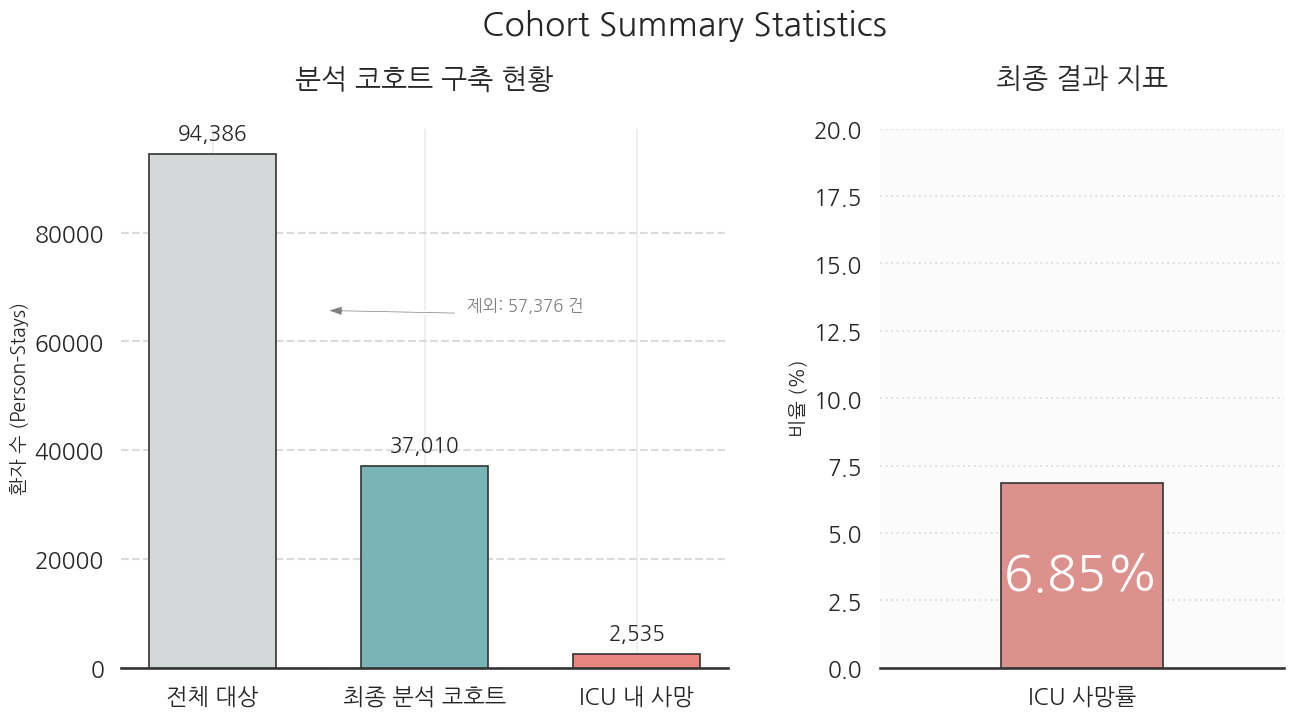

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Seaborn 테마 먼저 설정 (이게 폰트 설정을 초기화함)
sns.set_theme(style="whitegrid", context="talk")

# 2. 그 다음 한글 폰트 함수 실행 (반드시 테마 설정 뒤에!)
setup_korean_font_colab()

# 3. 추가적인 세부 스타일 조정 (구분선 및 테두리)
plt.rcParams['axes.edgecolor'] = '#333333' # 축 테두리 색상
plt.rcParams['grid.alpha'] = 0.3           # 구분선 투명도
plt.rcParams['axes.unicode_minus'] = False

# 컬러 팔레트
COLORS = ["#D4D8D9", "#79B4B7", "#E98580"]

# -----------------------------
# 시각화 실행
# -----------------------------
fig = plt.figure(figsize=(15, 7))
gs = fig.add_gridspec(1, 2, width_ratios=[1.5, 1], wspace=0.3)

# --- (A) 코호트 규모 흐름 ---
ax1 = fig.add_subplot(gs[0, 0])
labels = ["전체 대상", "최종 분석 코호트", "ICU 내 사망"]
values = [n_base, n_final, deaths]

# 막대 그래프 (zorder를 주어 구분선보다 위로 올림)
bars = ax1.bar(labels, values, color=COLORS, edgecolor='#333333', linewidth=1.2, width=0.6, zorder=3)

ax1.set_title("분석 코호트 구축 현황", pad=30, fontsize=20, fontweight='bold')
ax1.set_ylabel("환자 수 (Person-Stays)", fontsize=14)

excluded = n_base - n_final
ax1.annotate(f'제외: {excluded:,} 건',
             xy=(0.5, n_final + (excluded/2)),
             xytext=(1.2, (n_base + n_final)/2),
             arrowprops=dict(facecolor='gray', shrink=0.05, width=2, headwidth=8),
             fontsize=12, color='gray', fontweight='bold')

# Y축 구분선 강조 및 불필요한 테두리 제거
ax1.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)
sns.despine(ax=ax1, left=True) # 왼쪽 테두리 제거하여 개방감 부여

# 숫자 라벨링
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + (max(values)*0.02),
             f'{int(height):,}', ha='center', va='bottom',
             fontsize=15, fontweight='bold')

# --- (B) ICU 사망률 (Highlight Card 스타일) ---
ax2 = fig.add_subplot(gs[0, 1])

# 배경에 연한 그리드 박스 효과
ax2.patch.set_facecolor('#F8F9F9')
ax2.patch.set_alpha(0.5)

sns.barplot(x=["ICU 사망률"], y=[icu_mortality_rate], color=COLORS[2],
            edgecolor='#333333', linewidth=1.2, ax=ax2, width=0.4, zorder=3)

# 사망률 수치 강조
ax2.text(0, icu_mortality_rate / 2, f'{icu_mortality_rate:.2f}%',
         ha='center', va='center', fontsize=35, fontweight='bold', color='white', zorder=4)

ax2.set_title("최종 결과 지표", pad=30, fontsize=20, fontweight='bold')
ax2.set_ylabel("비율 (%)", fontsize=14)
ax2.set_ylim(0, max(20, icu_mortality_rate * 2))

# 보조 구분선 추가
ax2.grid(axis='y', linestyle=':', alpha=0.5)
sns.despine(ax=ax2, left=True)

plt.suptitle(f"Cohort Summary Statistics", y=1.05, fontsize=24, fontweight='black')
plt.tight_layout()
plt.show()

## 환자 인구통계학적 특성 시각화

✓ Colab 폰트 설정 완료: NanumGothic


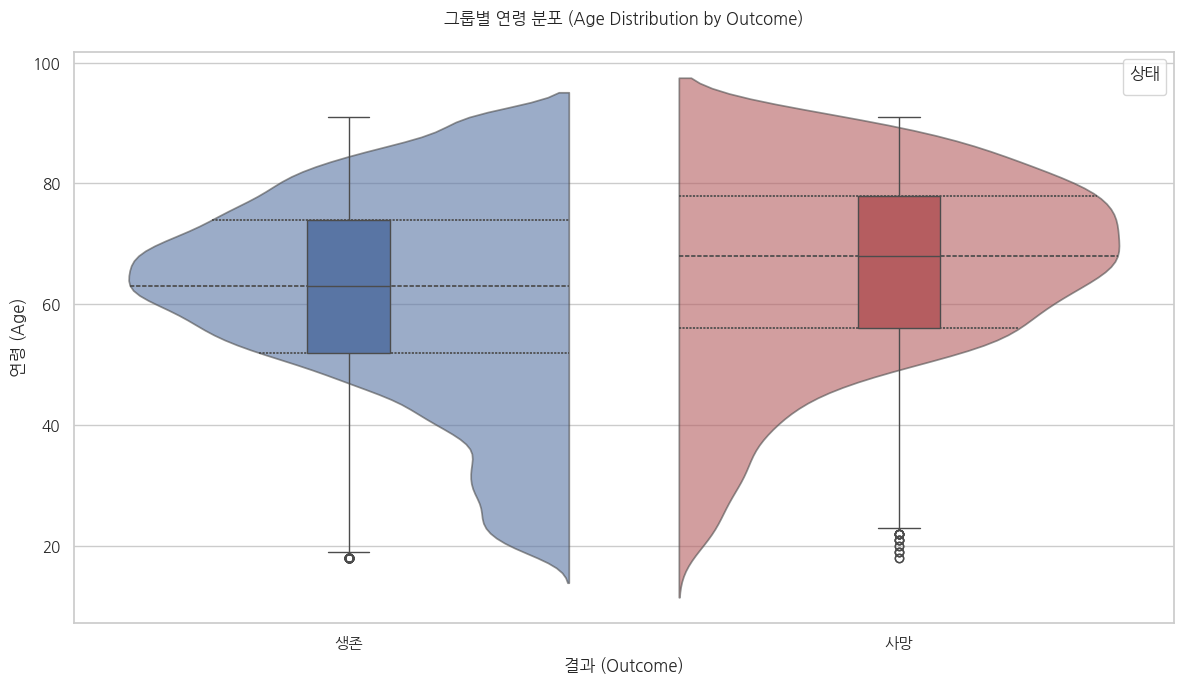

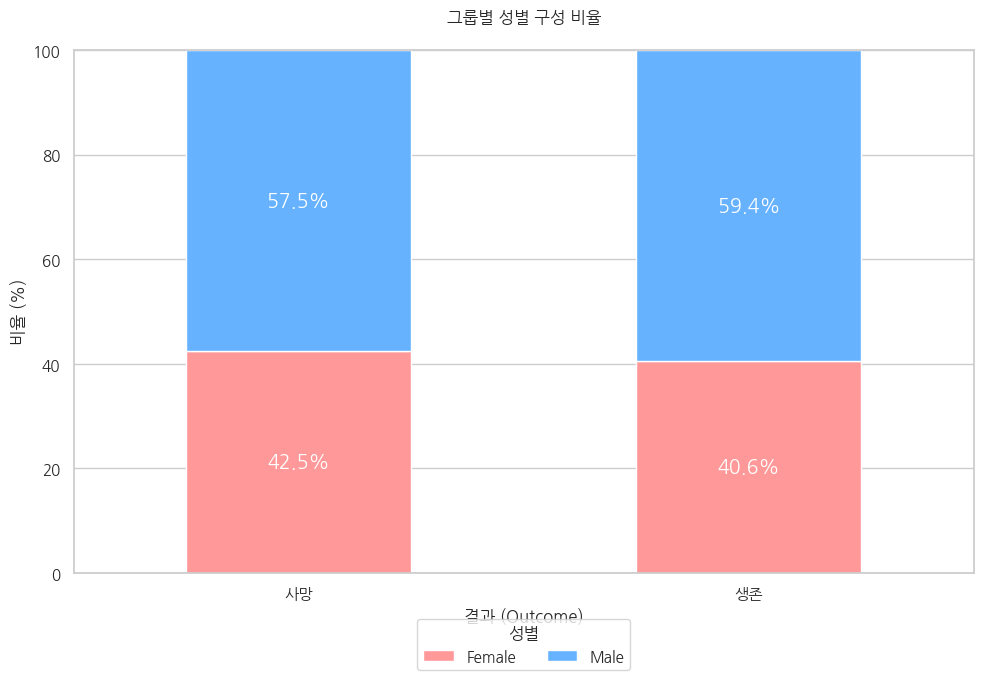

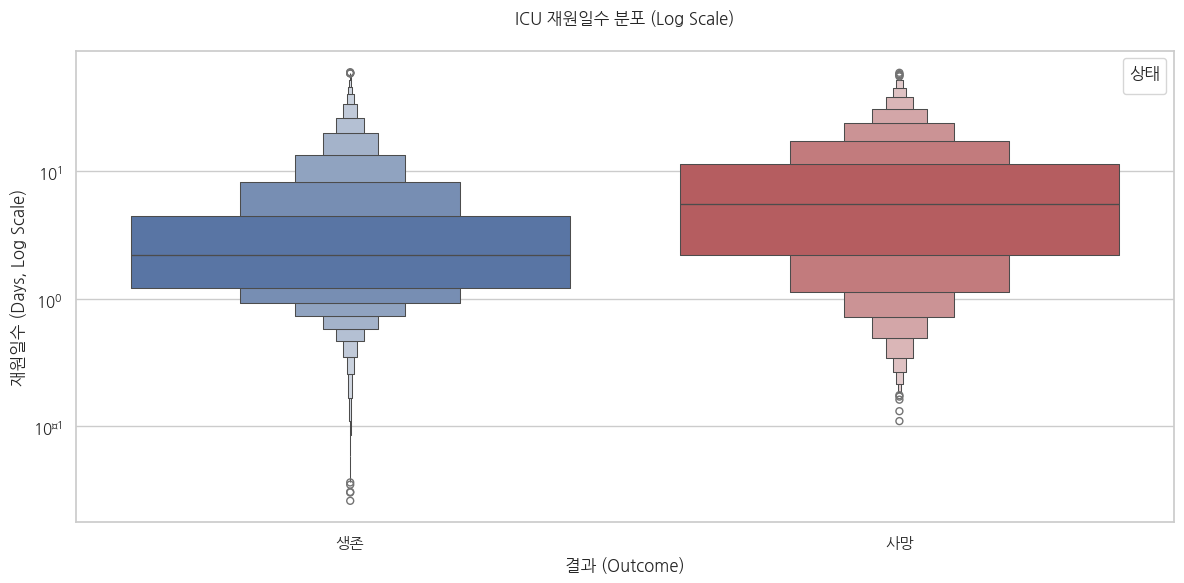

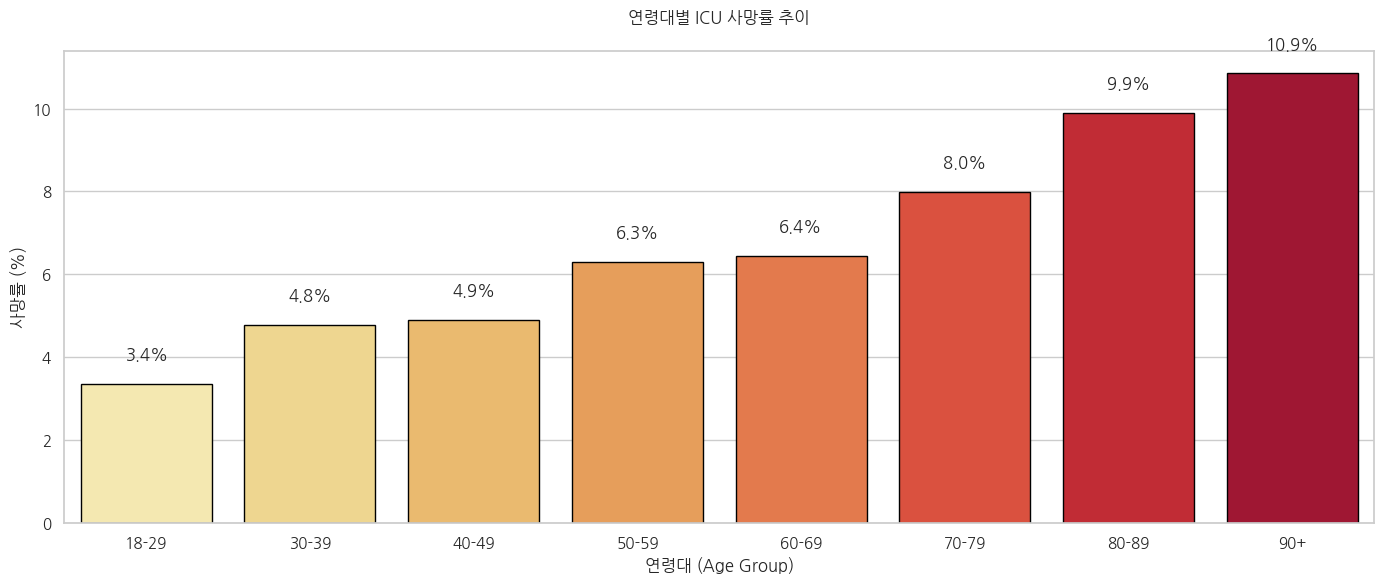

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 0) 발표용 스타일 및 한글 설정
# -----------------------------
# 한글 깨짐 방지 (환경에 맞게 폰트 설정 필요)
#plt.rcParams['font.family'] = 'Malgun Gothic' # Windows 기준
setup_korean_font_colab()
plt.rcParams['axes.unicode_minus'] = False
palette = {"생존": "#4C72B0", "사망": "#C44E52"} # 신뢰의 파랑, 위험의 빨강

# -----------------------------
# 1) 데이터 정리 (기존 코드 유지)
# -----------------------------
# (demo 생성 부분은 기존과 동일하다고 가정합니다)
# demo = ... (생략)

# -----------------------------
# 2) 시각화 1: 연령 분포 (Raincloud Plot 스타일)
#    - 지저분한 점 대신 바이올린+박스플롯 결합으로 밀도와 통계를 한눈에
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 7))

# 바이올린 플롯으로 밀도 확인
sns.violinplot(data=demo, x="outcome", y="age", hue="outcome",
               palette=palette, split=True, inner="quartile", alpha=0.6, ax=ax)

# 박스플롯을 얇게 겹쳐서 통계적 핵심(IQR) 강조
sns.boxplot(data=demo, x="outcome", y="age", hue="outcome",
            width=0.15, palette=palette, boxprops={'zorder': 2}, ax=ax, legend=False)

ax.set_title("그룹별 연령 분포 (Age Distribution by Outcome)", pad=20, fontweight='bold')
ax.set_xlabel("결과 (Outcome)")
ax.set_ylabel("연령 (Age)")
ax.legend(title="상태", loc="upper right")

plt.tight_layout()
plt.show()

# -----------------------------
# 3) 시각화 2: 성별 구성 (Stacked Bar Chart)
#    - 남/녀 비율을 한 막대에 쌓아서 직관적으로 비교
# -----------------------------
# 데이터 재구성
gender_dist = demo.groupby(['outcome', 'sex']).size().unstack(fill_value=0)
gender_pct = gender_dist.div(gender_dist.sum(axis=1), axis=0) * 100

# 시각화
ax = gender_pct.plot(kind='bar', stacked=True, figsize=(10, 7),
                    color=['#FF9999', '#66B2FF'], edgecolor='white')

ax.set_title("그룹별 성별 구성 비율", pad=20, fontweight='bold')
ax.set_ylabel("비율 (%)")
ax.set_xlabel("결과 (Outcome)")
ax.set_ylim(0, 100)
plt.xticks(rotation=0)

# 막대 안에 퍼센트 텍스트 추가
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    if height > 0:
        x, y = p.get_xy()
        ax.text(x + width/2, y + height/2, f'{height:.1f}%',
                ha='center', va='center', fontsize=14, color='white', fontweight='bold')

ax.legend(title="성별", labels=['Female', 'Male'], loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.tight_layout()
plt.show()

# -----------------------------
# 4) 시각화 3: ICU 재원일수 (Boxenplot + Log Scale)
#    - 데이터가 많을 때 일반 Boxplot보다 분위수를 더 상세히 보여줌
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxenplot(data=demo, x="outcome", y="los_days", hue="outcome", palette=palette, ax=ax)

ax.set_yscale("log")
ax.set_title("ICU 재원일수 분포 (Log Scale)", pad=20, fontweight='bold')
ax.set_xlabel("결과 (Outcome)")
ax.set_ylabel("재원일수 (Days, Log Scale)")
ax.legend(title="상태")

plt.tight_layout()
plt.show()

# -----------------------------
# 5) 시각화 4: 연령대별 사망률 (Gradation Color)
#    - 사망률이 높을수록 진해지는 컬러맵 적용
# -----------------------------
fig, ax = plt.subplots(figsize=(14, 6))
# 연령대별 사망률에 따라 색상 자동 지정
colors = sns.color_palette("Reds", len(mort_by_age))
sns.barplot(data=mort_by_age, x="age_bin", y="mortality_pct", hue="age_bin",
            palette="YlOrRd", edgecolor="black", ax=ax, legend=False)

ax.set_title("연령대별 ICU 사망률 추이", pad=20, fontweight='bold')
ax.set_xlabel("연령대 (Age Group)")
ax.set_ylabel("사망률 (%)")

# 상단에 데이터 라벨링
for i, r in mort_by_age.iterrows():
    ax.text(i, r["mortality_pct"] + 0.5, f'{r["mortality_pct"]:.1f}%',
            ha="center", va="bottom", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# 사용 피쳐 정의

### vital_events 정의

In [35]:
vital_itemid_extract = [
    220210, 220045, 220179, 220180, 223762, 223761, 220277,
    223901, 223900, 220739, 223835
]  # 추출용(화씨 포함)

vital_itemid_feature = [
    220210, 220045, 220179, 220180, 223762, 220277,
    223901, 223900, 220739, 223835
]


# chartevents itemid 라벨 확인
con.execute(f"""
SELECT itemid, label, unitname
FROM d_items
WHERE itemid IN ({",".join(map(str, vital_itemid_extract)) if vital_itemid_extract else "NULL"})
ORDER BY itemid;
""").fetchdf()


,itemid,label,unitname
0,220045,Heart Rate,bpm
1,220179,Non Invasive Blood Pressure systolic,mmHg
2,220180,Non Invasive Blood Pressure diastolic,mmHg
3,220210,Respiratory Rate,insp/min
4,220277,O2 saturation pulseoxymetry,%
5,220739,GCS - Eye Opening,None
6,223761,Temperature Fahrenheit,°F
7,223762,Temperature Celsius,°C
8,223835,Inspired O2 Fraction,None
9,223900,GCS - Verbal Response,None


### lab_event 정의

In [36]:
lab_itemid = [
    50861, 50862, 50878, 50863, 50885, 51006, 50893, 50902, 50912, 50931,
    51222, 51221, 50882, 50818, 50821, 51265, 50971, 50976, 51237, 51279,
    50983, 51300
]


# labevents itemid 라벨 확인
con.execute(f"""
SELECT itemid, label, fluid, category
FROM d_labitems
WHERE itemid IN ({",".join(map(str, lab_itemid)) if lab_itemid else "NULL"})
ORDER BY itemid;
""").fetchdf()


,itemid,label,fluid,category
0,50818,pCO2,Blood,Blood Gas
1,50821,pO2,Blood,Blood Gas
2,50861,Alanine Aminotransferase (ALT),Blood,Chemistry
3,50862,Albumin,Blood,Chemistry
4,50863,Alkaline Phosphatase,Blood,Chemistry
5,50878,Asparate Aminotransferase (AST),Blood,Chemistry
6,50882,Bicarbonate,Blood,Chemistry
7,50885,"Bilirubin, Total",Blood,Chemistry
8,50893,"Calcium, Total",Blood,Chemistry
9,50902,Chloride,Blood,Chemistry


# 이벤트 추출

### 단위 표준화
  - 사용하는 피쳐별 정상 범위 설정

In [37]:
import pandas as pd


valid_ranges = [
    # --- Vital (chartevents) ---
    {"itemid": 220045, "min": 10,  "max": 190},  # Heart rate (/min)
    {"itemid": 220179, "min": 40,  "max": 230},  # SBP (mmHg)
    {"itemid": 220180, "min": 20,  "max": 130},  # DBP (mmHg)
    {"itemid": 220210, "min": 5,   "max": 50},   # Respiratory rate (/min)
    {"itemid": 223762, "min": 32,  "max": 50},   # Body temperature (°C)
    {"itemid": 220277, "min": 68,  "max": 100},  # SpO2 (%)
    {"itemid": 223901, "min": 1,   "max": 6},    # GCS - motor
    {"itemid": 223900, "min": 1,   "max": 5},    # GCS - verbal
    {"itemid": 220739, "min": 1,   "max": 4},    # GCS - eye
    {"itemid": 223835, "min": 20,  "max": 100},  # FiO2 (%)

    # --- Lab (labevents) ---
    {"itemid": 50861, "min": 0,    "max": 5000},   # ALT (Units/L)
    {"itemid": 50862, "min": 0,    "max": 5.5},    # Albumin (g/dL)
    {"itemid": 50878, "min": 0,    "max": 10000},  # AST (Units/L)
    {"itemid": 50863, "min": 0,    "max": 3000},   # ALP
    {"itemid": 50885, "min": 0,    "max": 50},     # Bilirubin, Total (mg/dL)
    {"itemid": 51006, "min": 0,    "max": 150},    # BUN (mg/dL)
    {"itemid": 50893, "min": 5,    "max": 15},     # Calcium (mg/dL)
    {"itemid": 50902, "min": 70,   "max": 135},    # Chloride (mmol/L)
    {"itemid": 50912, "min": 0,    "max": 15},     # Creatinine (mg/dL)
    {"itemid": 50931, "min": 0,    "max": 600},    # Glucose (mg/dL)
    {"itemid": 51222, "min": 0,    "max": 25},     # Hemoglobin (g/dL)
    {"itemid": 51221, "min": 10,   "max": 60},     # Hematocrit (%)
    {"itemid": 50882, "min": 0,    "max": 100},    # HCO3- (mmol/L)
    {"itemid": 50818, "min": 10,   "max": 100},    # paCO2 (mmHg)
    {"itemid": 50821, "min": 30,   "max": 500},    # paO2 (mmHg)

    # ⚠️ 이미지에 'Platelets (k/µL) 70~135'로 찍혀 있음 (임상적으로는 낮아 보이지만 요청대로 그대로 반영)
    {"itemid": 51265, "min": 70,   "max": 135},    # Platelet Count

    {"itemid": 50971, "min": 2,    "max": 8},      # Potassium (mmol/L)
    {"itemid": 50976, "min": 2,    "max": 10},     # Protein, Total (g/dL)
    {"itemid": 51237, "min": 0,    "max": 8},      # INR(PT)
    {"itemid": 51279, "min": 0,    "max": 10},     # RBC (m/µL)
    {"itemid": 50983, "min": 105,  "max": 170},    # Sodium (mmol/L)
    {"itemid": 51300, "min": 0,    "max": 90},     # WBC (k/µL)
]

vr_df = pd.DataFrame(valid_ranges)
con.register("valid_ranges_df", vr_df)

con.execute("DROP TABLE IF EXISTS valid_ranges;")
con.execute("""
CREATE TABLE valid_ranges AS
SELECT
  itemid::INTEGER AS itemid,
  min::DOUBLE AS vmin,
  max::DOUBLE AS vmax
FROM valid_ranges_df;
""")

con.execute("SELECT COUNT(*) AS n_ranges FROM valid_ranges;").fetchdf()


,n_ranges
0,32


### 지정한 itemid별 데이터 개수 출력

In [38]:
import pandas as pd

# itemid 리스트 테이블 등록(기존 방식 유지)
con.register("vital_itemid_df", pd.DataFrame({"itemid": vital_itemid_extract}))
con.register("lab_itemid_df",   pd.DataFrame({"itemid": lab_itemid}))

con.execute("DROP TABLE IF EXISTS vital_itemids;")
con.execute("DROP TABLE IF EXISTS lab_itemids;")
con.execute("CREATE TABLE vital_itemids AS SELECT DISTINCT itemid::INTEGER AS itemid FROM vital_itemid_df;")
con.execute("CREATE TABLE lab_itemids   AS SELECT DISTINCT itemid::INTEGER AS itemid FROM lab_itemid_df;")

con.execute("DROP TABLE IF EXISTS events_long;")
con.execute("""
CREATE TABLE events_long AS
WITH
ce AS (
  SELECT
    cs.subject_id, cs.hadm_id, cs.stay_id,
    cs.intime, cs.outtime, cs.deathtime, cs.death_in_icu,
    'chartevents' AS source,
    ce.charttime::TIMESTAMP AS charttime,
    ce.storetime::TIMESTAMP AS storetime,

    -- ✅ (1) itemid 표준화: 화씨(223761)도 섭씨 체온 itemid(223762)로 합침
    CASE
      WHEN ce.itemid::INTEGER = 223761 THEN 223762
      ELSE ce.itemid::INTEGER
    END AS itemid,

    -- ✅ (2) 값 표준화: 화씨면 섭씨로 변환
    CASE
      WHEN ce.itemid::INTEGER = 223761 THEN (ce.valuenum::DOUBLE - 32.0) * (5.0/9.0)
      ELSE ce.valuenum::DOUBLE
    END AS value_conv

  FROM chartevents ce
  JOIN cohort_stays cs ON cs.stay_id = ce.stay_id
  JOIN vital_itemids vi ON vi.itemid = ce.itemid
  WHERE ce.charttime IS NOT NULL
    AND ce.valuenum IS NOT NULL
    -- ✅ (옵션이지만 강추) ICU 시간 범위로 자르기: 불필요한 row 폭증 방지
    AND ce.charttime::TIMESTAMP BETWEEN cs.intime AND cs.outtime
),

ce_filtered AS (
  SELECT
    ce.*,
    CASE
      WHEN vr.itemid IS NULL THEN ce.value_conv
      WHEN ce.value_conv BETWEEN vr.vmin AND vr.vmax THEN ce.value_conv
      ELSE NULL
    END AS value
  FROM ce
  LEFT JOIN valid_ranges vr ON vr.itemid = ce.itemid   -- ✅ 표준화된 itemid로 조인
  WHERE (vr.itemid IS NULL OR ce.value_conv BETWEEN vr.vmin AND vr.vmax)
),

le AS (
  SELECT
    cs.subject_id, cs.hadm_id, cs.stay_id,
    cs.intime, cs.outtime, cs.deathtime, cs.death_in_icu,
    'labevents' AS source,
    COALESCE(le.charttime::TIMESTAMP, le.storetime::TIMESTAMP) AS charttime,
    le.storetime::TIMESTAMP AS storetime,
    le.itemid::INTEGER AS itemid,
    le.valuenum::DOUBLE AS value_raw
  FROM labevents le
  JOIN cohort_stays cs
    ON cs.hadm_id = le.hadm_id
   AND COALESCE(le.charttime::TIMESTAMP, le.storetime::TIMESTAMP) BETWEEN cs.intime AND cs.outtime
  JOIN lab_itemids li ON li.itemid = le.itemid
  WHERE COALESCE(le.charttime::TIMESTAMP, le.storetime::TIMESTAMP) IS NOT NULL
    AND le.valuenum IS NOT NULL
),

le_filtered AS (
  SELECT
    le.*,
    CASE
      WHEN vr.itemid IS NULL THEN le.value_raw
      WHEN le.value_raw BETWEEN vr.vmin AND vr.vmax THEN le.value_raw
      ELSE NULL
    END AS value
  FROM le
  LEFT JOIN valid_ranges vr ON vr.itemid = le.itemid
  WHERE (vr.itemid IS NULL OR le.value_raw BETWEEN vr.vmin AND vr.vmax)
),

u AS (
  SELECT
    subject_id, hadm_id, stay_id,
    intime, outtime, deathtime, death_in_icu,
    source, charttime, storetime, itemid, value
  FROM ce_filtered
  UNION ALL
  SELECT
    subject_id, hadm_id, stay_id,
    intime, outtime, deathtime, death_in_icu,
    source, charttime, storetime, itemid, value
  FROM le_filtered
),

dedup AS (
  SELECT
    subject_id, hadm_id, stay_id,
    intime, outtime, deathtime, death_in_icu,
    source, charttime, itemid,
    arg_max(value, COALESCE(storetime, charttime)) AS value
  FROM u
  GROUP BY
    subject_id, hadm_id, stay_id,
    intime, outtime, deathtime, death_in_icu,
    source, charttime, itemid
)

SELECT * FROM dedup;
""")

con.execute("SELECT source, COUNT(*) AS n FROM events_long GROUP BY source;").fetchdf()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,source,n
0,labevents,4360931
1,chartevents,22730541


# 이벤트 기반 time_index + delta 파생변수 생성

In [39]:
# time_index
con.execute("DROP TABLE IF EXISTS time_index;")
con.execute("""
CREATE TABLE time_index AS
SELECT stay_id, charttime
FROM events_long
GROUP BY stay_id, charttime;
""")

# event_flags
con.execute("DROP TABLE IF EXISTS event_flags;")
con.execute("""
CREATE TABLE event_flags AS
SELECT
  stay_id,
  charttime,
  MAX(CASE WHEN source='chartevents' THEN 1 ELSE 0 END) AS vital_flag,
  MAX(CASE WHEN source='labevents'  THEN 1 ELSE 0 END) AS lab_flag
FROM events_long
GROUP BY stay_id, charttime;
""")

# deltas
con.execute("DROP TABLE IF EXISTS deltas;")
con.execute("""
CREATE TABLE deltas AS
SELECT
  stay_id,
  charttime,
  date_diff(
    'second',
    MAX(CASE WHEN vital_flag=1 THEN charttime END)
      OVER (PARTITION BY stay_id ORDER BY charttime ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW),
    charttime
  )/3600.0 AS delta_vital_hr,

  date_diff(
    'second',
    MAX(CASE WHEN lab_flag=1 THEN charttime END)
      OVER (PARTITION BY stay_id ORDER BY charttime ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW),
    charttime
  )/3600.0 AS delta_lab_hr
FROM event_flags;
""")


# wide pivot
  - 행으로 들어가있는 itemid를 컬럼으로 변경하는 과정

In [40]:
# pivot 컬럼 SQL 생성
all_itemids = sorted(set(vital_itemid_feature) | set(lab_itemid))

pivot_cols_sql = ",\n  ".join([
    f"MAX(CASE WHEN e.itemid = {iid} THEN e.value END) AS item_{iid}"
    for iid in all_itemids
])

con.execute("DROP TABLE IF EXISTS timeseries_wide;")
con.execute(f"""
CREATE TABLE timeseries_wide AS
SELECT
  cs.subject_id, cs.hadm_id, cs.stay_id,
  ti.charttime,
  cs.intime, cs.outtime, cs.deathtime, cs.death_in_icu,
  cs.age, cs.sex,
  {pivot_cols_sql}
FROM time_index ti
JOIN cohort_stays cs ON cs.stay_id = ti.stay_id
LEFT JOIN events_long e ON e.stay_id=ti.stay_id AND e.charttime=ti.charttime
GROUP BY
  cs.subject_id, cs.hadm_id, cs.stay_id,
  ti.charttime,
  cs.intime, cs.outtime, cs.deathtime, cs.death_in_icu,
  cs.age, cs.sex
;
""")

con.execute("DROP TABLE IF EXISTS dataset_base;")
con.execute("""
CREATE TABLE dataset_base AS
SELECT
  t.*,
  d.delta_vital_hr,
  d.delta_lab_hr
FROM timeseries_wide t
LEFT JOIN deltas d
  ON d.stay_id=t.stay_id AND d.charttime=t.charttime
;
""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

# 논문 방식 트리밍 + 라벨(y)
  - 비식별화된 시간 데이터를 실제 데이터로 변경 및 타임스탬프 별 사망 여부 피쳐 생성

In [41]:
con.execute("DROP TABLE IF EXISTS dataset_final;")
con.execute("""
CREATE TABLE dataset_final AS
SELECT
  *,
  CASE
    WHEN death_in_icu=1
     AND charttime BETWEEN (deathtime - INTERVAL '24 hours') AND deathtime
    THEN 1 ELSE 0 END AS y
FROM dataset_base
WHERE
  (death_in_icu=0)
  OR (death_in_icu=1 AND charttime BETWEEN (deathtime - INTERVAL '24 hours') AND deathtime)
;
""")

con.execute("SELECT COUNT(*) AS n_rows, SUM(y) AS n_event_rows FROM dataset_final;").fetchdf()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,n_rows,n_event_rows
0,6093811,106227.0


# 시각화 자료

## 변수별 분포 비율 + 결측치 비율

✓ Colab 폰트 설정 완료: NanumGothic


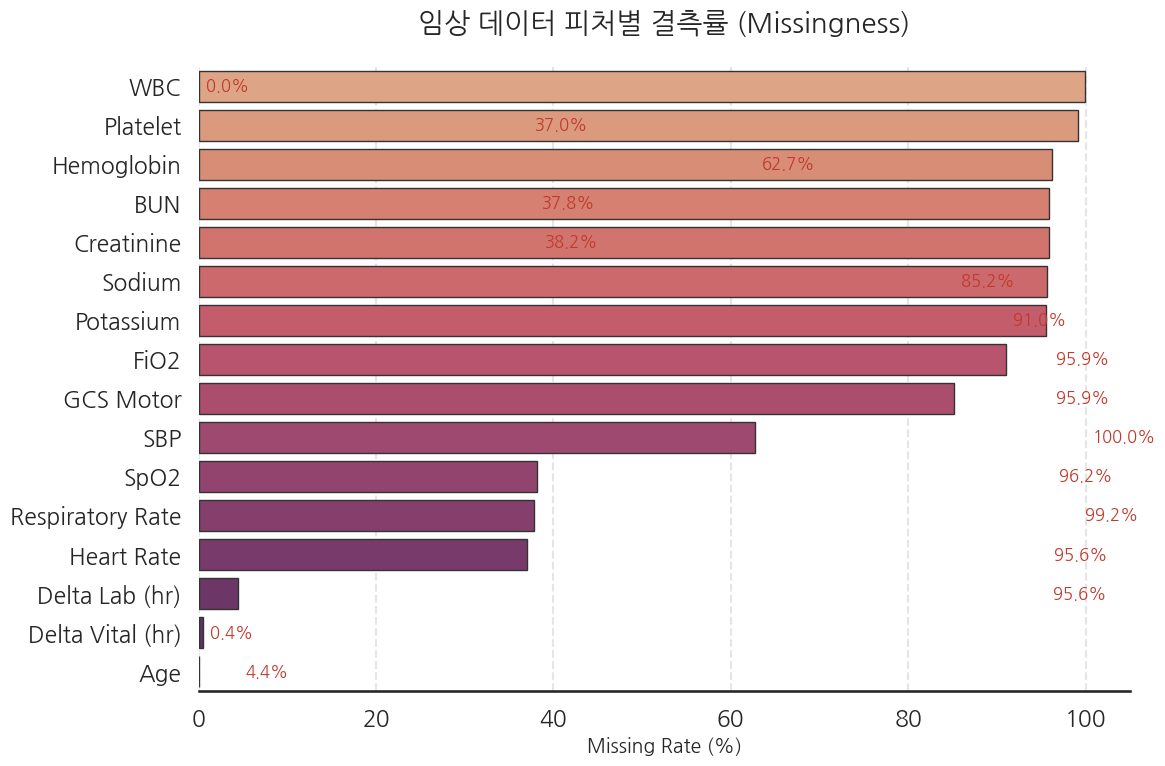

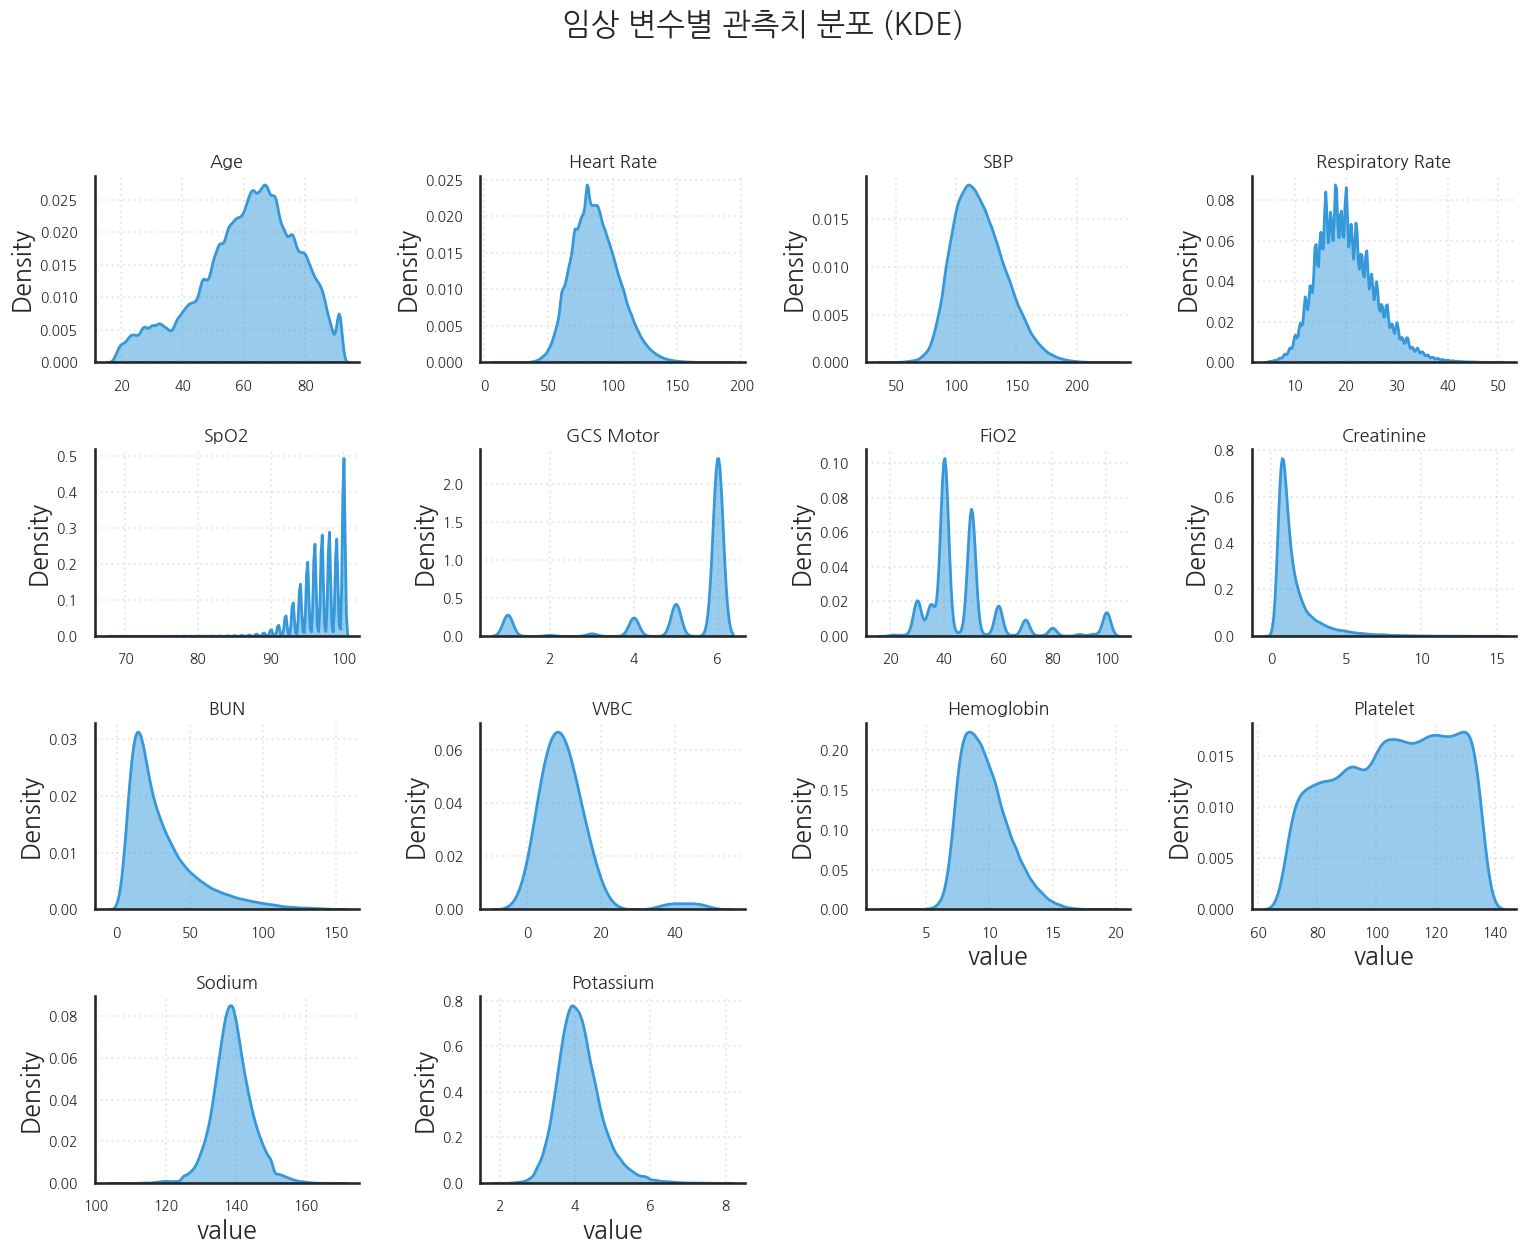

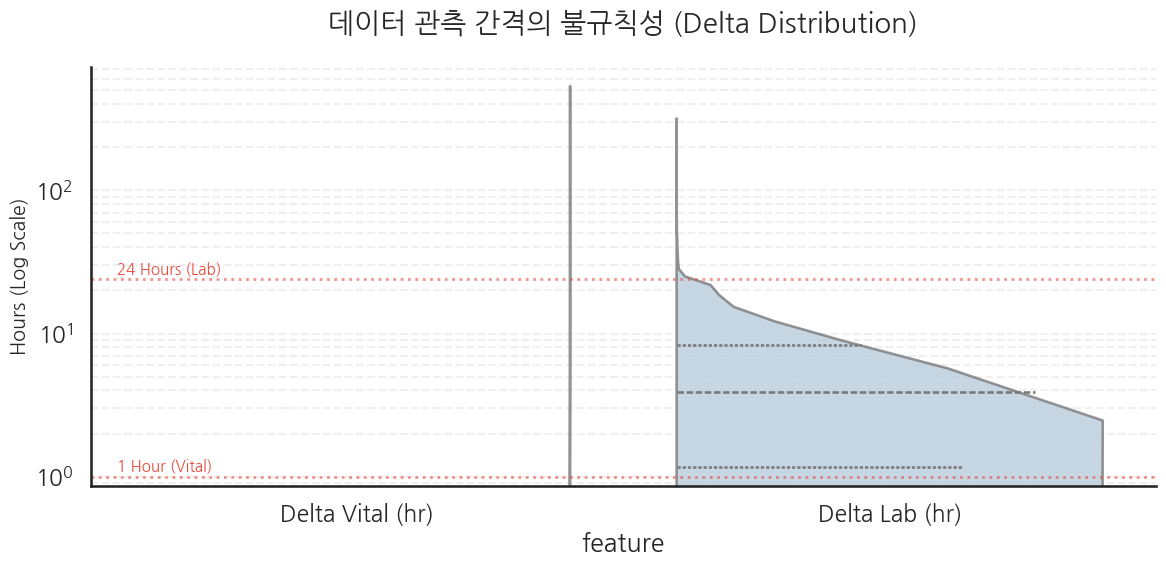

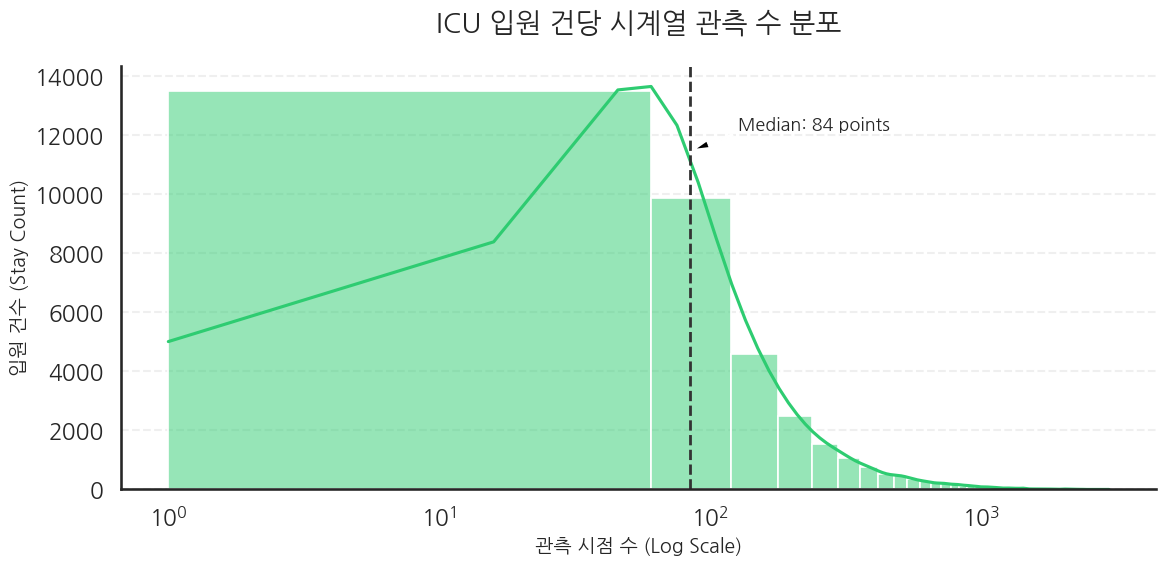

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 0) 스타일 및 테마 설정 (폰트 설정 포함)
# -----------------------------
sns.set_theme(style="white", context="talk")
setup_korean_font_colab() # 사용자 정의 함수 호출
plt.rcParams["axes.unicode_minus"] = False

# 시각화용 메인 컬러
COLOR_NORMAL = "#3498DB"   # 신뢰의 블루 (KDE용)
COLOR_STAY = "#2ECC71"     # 성장의 그린 (Stay 밀도용)

# -----------------------------
# 1) 주요 피처 정의 및 스키마 검사
# -----------------------------
MAIN_FEATURES = {
    "Age": "age",
    "Heart Rate": "item_220045",
    "SBP": "item_220179",
    "Respiratory Rate": "item_220210",
    "SpO2": "item_220277",
    "GCS Motor": "item_223901",
    "FiO2": "item_223835",
    "Creatinine": "item_50912",
    "BUN": "item_51006",
    "WBC": "item_51300",
    "Hemoglobin": "item_51222",
    "Platelet": "item_51265",
    "Sodium": "item_50983",
    "Potassium": "item_50971",

}

# 역매핑 (시각화 라벨용)
rev_map = {v: k for k, v in MAIN_FEATURES.items()}

# 존재 여부 확인
schema = con.execute("SELECT name FROM pragma_table_info('dataset_final')").fetchdf()["name"].tolist()
missing_cols = [v for v in MAIN_FEATURES.values() if v not in schema]
assert len(missing_cols) == 0, f"dataset_final에 없는 주요 feature: {missing_cols}"

# -----------------------------
# 2) 결측 비율 계산 (DuckDB)
# -----------------------------
exprs = ",\n".join([f"AVG(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) AS {col}" for col in MAIN_FEATURES.values()])
q = f"SELECT {exprs} FROM dataset_final;"
miss = con.execute(q).fetchdf().T.reset_index()
miss.columns = ["col", "missing_rate"]
miss["missing_pct"] = miss["missing_rate"] * 100
miss["feature"] = miss["col"].map(rev_map)
miss = miss.sort_values("missing_pct", ascending=False)

# -----------------------------
# 3) 시각화 A: 주요 피처 결측 비율
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 8))

# 결측률이 높을수록 진한 빨간색을 띠는 팔레트
sns.barplot(
    data=miss, x="missing_pct", y="feature",
    palette="flare", edgecolor="#333333", linewidth=1, ax=ax
)

# 보조선 및 깔끔한 마무리
ax.grid(axis='x', linestyle='--', alpha=0.5)
sns.despine(left=True)

ax.set_title("임상 데이터 피처별 결측률 (Missingness)", pad=25, fontsize=20, fontweight='bold')
ax.set_xlabel("Missing Rate (%)", fontsize=14)
ax.set_ylabel("")

for i, r in miss.iterrows():
    ax.text(r["missing_pct"] + 0.8, i, f'{r["missing_pct"]:.1f}%',
            va="center", fontsize=12, fontweight='bold', color='#C0392B')

plt.tight_layout()
plt.show()

# -----------------------------
# 4) 데이터 분포 준비 (Sampling)
# -----------------------------
sample_df = con.execute(f"""
    SELECT {", ".join(MAIN_FEATURES.values())}
    FROM dataset_final USING SAMPLE 30 PERCENT (bernoulli);
""").fetchdf()

long_df = sample_df.melt(var_name="col", value_name="value")
long_df["feature"] = long_df["col"].map(rev_map)
long_df["is_delta"] = long_df["feature"].str.contains("Delta")

# -----------------------------
# 5) 시각화 B-1: 일반 피처 값 분포 (FacetGrid)
# -----------------------------
normal_features = long_df[~long_df["is_delta"]].dropna()

# 배경 그리드가 포함된 세련된 개별 분포도
g = sns.FacetGrid(normal_features, col="feature", col_wrap=4,
                  sharex=False, sharey=False, height=3, aspect=1.3)
g.map(sns.kdeplot, "value", fill=True, color=COLOR_NORMAL, alpha=0.5, linewidth=2)

g.set_titles("{col_name}", fontweight='bold', size=13)
g.fig.suptitle("임상 변수별 관측치 분포 (KDE)", y=1.05, fontsize=22, fontweight='bold')

for ax in g.axes.flat:
    ax.grid(axis='both', linestyle=':', alpha=0.4)
    ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

# -----------------------------
# 6) 시각화 B-2: 관측 간격(Delta) 불규칙성
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 6))

sns.violinplot(
    data=long_df[long_df["is_delta"]], x="feature", y="value",
    palette="Pastel1", inner="quartile", split=True, ax=ax, alpha=0.8
)

ax.set_yscale("log")
ax.set_title("데이터 관측 간격의 불규칙성 (Delta Distribution)", pad=25, fontsize=20, fontweight='bold')
ax.set_ylabel("Hours (Log Scale)", fontsize=14)
ax.grid(axis='y', which='both', linestyle='--', alpha=0.3)

# 임상적 의미를 갖는 가이드라인 추가
ax.axhline(1, color='#E74C3C', linestyle=':', linewidth=2, alpha=0.6)
ax.text(-0.45, 1.1, "1 Hour (Vital)", color='#E74C3C', fontweight='bold', fontsize=11)
ax.axhline(24, color='#E74C3C', linestyle=':', linewidth=2, alpha=0.6)
ax.text(-0.45, 26, "24 Hours (Lab)", color='#E74C3C', fontweight='bold', fontsize=11)

sns.despine()
plt.tight_layout()
plt.show()

# -----------------------------
# 7) 시각화 C: Stay 단위 데이터 밀도
# -----------------------------
stay_obs = con.execute("SELECT stay_id, COUNT(*) AS n_rows FROM dataset_final GROUP BY stay_id").fetchdf()

fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(stay_obs["n_rows"], bins=50, kde=True, color=COLOR_STAY, edgecolor="white", alpha=0.5, ax=ax)

ax.set_xscale("log")
ax.set_title("ICU 입원 건당 시계열 관측 수 분포", pad=25, fontsize=20, fontweight='bold')
ax.set_xlabel("관측 시점 수 (Log Scale)", fontsize=14)
ax.set_ylabel("입원 건수 (Stay Count)", fontsize=14)

# 중앙값 표시
med = stay_obs["n_rows"].median()
ax.axvline(med, color='#333333', linestyle='--', linewidth=2)
ax.annotate(f'Median: {med:.0f} points', xy=(med, ax.get_ylim()[1]*0.8),
            xytext=(med*1.5, ax.get_ylim()[1]*0.85),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6),
            fontsize=13, fontweight='bold')

ax.grid(axis='y', linestyle='--', alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()

In [1]:
stay_obs = con.execute("""
SELECT stay_id, COUNT(*) AS n_rows
FROM dataset_final
GROUP BY stay_id
""").fetchdf()

# 로그 구간 bins 생성 (10^0 ~ 10^4)
bins = np.logspace(
    np.log10(stay_obs["n_rows"].min()),
    np.log10(stay_obs["n_rows"].max()),
    20
)

fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(stay_obs["n_rows"], bins=bins, edgecolor="white", alpha=0.8)
ax.set_xscale("log")

ax.set_title(
    "ICU stay별 관측 시점 수 분포 (Log-binned)\n"
    "기준: 관측 시점 수를 로그 구간(10¹, 10², 10³ 단위)으로 실제 집계"
)
ax.set_xlabel("Rows per stay (log scale)")
ax.set_ylabel("Number of stays")

med = stay_obs["n_rows"].median()
ax.axvline(med, color="black", linestyle="--", linewidth=2)
ax.text(med, ax.get_ylim()[1]*0.85, f"Median = {med:.0f}", ha="center", fontweight="bold")

plt.tight_layout()
plt.show()


NameError: name 'con' is not defined

# 최종 csv파일 생성

In [ ]:
EVENT_ITEMIDS = vital_itemid_feature + lab_itemid
assert len(EVENT_ITEMIDS) == 32, f"EVENT_ITEMIDS={len(EVENT_ITEMIDS)}개 (32개여야 함)"

STATIC_COLS = ["age", "sex"]
EVENT_COLS  = [f"item_{iid}" for iid in EVENT_ITEMIDS]
FEATURE_COLS = STATIC_COLS + EVENT_COLS

assert len(FEATURE_COLS) == 34, f"FEATURE_COLS={len(FEATURE_COLS)}개 (34개여야 함)"


In [ ]:
missing = []
schema = con.execute("SELECT name FROM pragma_table_info('dataset_final')").fetchdf()["name"].tolist()
schema_set = set(schema)

for c in FEATURE_COLS:
    if c not in schema_set:
        missing.append(c)

print("missing columns:", missing)
assert len(missing) == 0, f"dataset_final에 없는 컬럼: {missing}"


missing columns: []


In [ ]:
cols_df = con.execute("""
SELECT
  row_number() OVER () AS idx,
  name,
  type
FROM pragma_table_info('dataset_final')
ORDER BY idx;
""").fetchdf()

print("n_cols(dataset_final) =", len(cols_df))
cols_df


n_cols(dataset_final) = 45


,idx,name,type
0,1,subject_id,BIGINT
1,2,hadm_id,BIGINT
2,3,stay_id,BIGINT
3,4,charttime,TIMESTAMP
4,5,intime,TIMESTAMP
5,6,outtime,TIMESTAMP
6,7,deathtime,TIMESTAMP
7,8,death_in_icu,INTEGER
8,9,age,INTEGER
9,10,sex,VARCHAR


In [ ]:
import os, shutil
from pathlib import Path

# =========================
# 0) 출력 경로
# =========================
OUT_LOCAL = "/content/out_by_subject_csv"  # 로컬(Colab VM)
OUT_DRIVE_DIR = "/content/drive/MyDrive/mimic_exports"  # 드라이브 저장 폴더
ZIP_PATH = "/content/out_by_subject_csv.zip"

# 폴더 정리
shutil.rmtree(OUT_LOCAL, ignore_errors=True)
os.makedirs(OUT_LOCAL, exist_ok=True)
os.makedirs(OUT_DRIVE_DIR, exist_ok=True)

# =========================
# 1) 내보낼 컬럼 구성
#   - 논문 스타일: 이벤트 기반 시점 row + 정적(age/sex) + 임상 변수(item_*) + delta 2개
#   - label은 open-source 포맷에 맞춰 died_in_icu 사용
# =========================
EVENT_ITEMIDS = vital_itemid_feature + lab_itemid   # (현재 너 노트북 기준 32개)
EVENT_COLS = [f"item_{iid}" for iid in EVENT_ITEMIDS]

# sex를 숫자로 인코딩 (M=1, F=0, 그 외 NULL)
SEX_SQL = """
CASE
  WHEN lower(sex) IN ('m','male') THEN 1
  WHEN lower(sex) IN ('f','female') THEN 0
  ELSE NULL
END
"""

# feature1..N 으로 강제 리네이밍(오픈소스 호환성↑)
# feature1=age, feature2=sex, feature3..=item, 마지막 2개=delta
feature_exprs = []
feature_exprs.append("age::DOUBLE AS feature1")
feature_exprs.append(f"({SEX_SQL})::DOUBLE AS feature2")

# item features
for i, col in enumerate(EVENT_COLS, start=3):
    feature_exprs.append(f"{col}::DOUBLE AS feature{i}")

# delta features를 맨 뒤에 붙임 (논문 전처리 구성요소)
feature_exprs.append(f"delta_vital_hr::DOUBLE AS feature{len(feature_exprs)+1}")
feature_exprs.append(f"delta_lab_hr::DOUBLE AS feature{len(feature_exprs)+1}")

FEATURE_SQL = ",\n  ".join(feature_exprs)
N_FEATURES = len(feature_exprs)
print("Export features =", N_FEATURES, "(= age+sex + items + 2 deltas)")

# =========================
# 2) subject_id 목록 가져오기
# =========================
subjects = con.execute("SELECT DISTINCT subject_id FROM dataset_final ORDER BY subject_id;").fetchdf()["subject_id"].tolist()
print("n_subjects =", len(subjects))

# =========================
# 3) 환자별 CSV 생성 (DuckDB COPY가 제일 빠름)
# =========================
for sid in subjects:
    out_fp = f"{OUT_LOCAL}/{int(sid)}.csv"

    con.execute(f"""
    COPY (
      SELECT
        stay_id::BIGINT AS patientunitstayid,
        death_in_icu::INTEGER AS died_in_icu,
        date_diff('minute', intime::TIMESTAMP, charttime::TIMESTAMP)::INTEGER AS observationoffset,
        {FEATURE_SQL}
      FROM dataset_final
      WHERE subject_id = {int(sid)}
      ORDER BY stay_id, observationoffset
    )
    TO '{out_fp}'
    (HEADER, DELIMITER ',');
    """)

print("✅ per-subject csv done ->", OUT_LOCAL)

# =========================
# 4) ZIP 압축 + Drive 복사
# =========================
if os.path.exists(ZIP_PATH):
    os.remove(ZIP_PATH)

shutil.make_archive("/content/out_by_subject_csv", "zip", OUT_LOCAL)
print("ZIP:", ZIP_PATH)

dst = f"{OUT_DRIVE_DIR}/out_by_subject_csv.zip"
shutil.copy2(ZIP_PATH, dst)
print("✅ COPIED TO DRIVE:", dst)


Export features = 36 (= age+sex + items + 2 deltas)
n_subjects = 29900
✅ per-subject csv done -> /content/out_by_subject_csv
ZIP: /content/out_by_subject_csv.zip
✅ COPIED TO DRIVE: /content/drive/MyDrive/mimic_exports/out_by_subject_csv.zip
